In [4]:
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import os
from sklearn import metrics

In [5]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [6]:
train = pd.read_csv('train.csv') 
validation = pd.read_csv('validation.csv') 
test = pd.read_csv('test.csv')

In [7]:
# Checking how many missing values we have in train data
train.isnull().sum()

click                   0
weekday                 0
hour                    0
bidid                   0
userid                  0
useragent               0
IP                      0
region                  0
city                    0
adexchange          49829
domain             137135
url                 86812
urlid             2430981
slotid                  0
slotwidth               0
slotheight              0
slotvisibility          0
slotformat              0
slotprice               0
creative                0
bidprice                0
payprice                0
keypage            504990
advertiser              0
usertag            497479
dtype: int64

## Feature engineering

In [8]:
def preprocess_df(df):

    
    #---real price-----    
    if 'bidprice' and 'payprice' in df.columns:
        df['bidprice'] = df['bidprice'].apply( lambda x: x/1000.0 )
        df['payprice'] = df['payprice'].apply( lambda x: x/1000.0 )
       
        
    #---slot area-----  
    df['slot_area']=df['slotwidth'] * df['slotheight'] 
    

    #----real price---   
    df['slotprice'] = df['slotprice'].apply( lambda x: x/1000.0 )
    
    
    # ----browser/OS splitting--    
    df['OS'] = df['useragent'].apply( lambda x: x.split('_')[0] )
    df['browser'] = df['useragent'].apply( lambda x: x.split('_')[1] ) 
    df['OS'] = df['OS'].astype('category')
    df['browser'] = df['browser'].astype('category')
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    
    
    df['advertiser'] = df['advertiser'].astype('category')
    df['adexchange'] = df['adexchange'].astype('category')
    df['city'] = df['city'].astype('category')
    df['region'] = df['region'].astype('category')
    df['weekday'] = df['weekday'].astype('category')

    return df   


# Usertag separation
def tag(df):
    df['usertag'] = df['usertag'].apply(lambda x: str(x).split(','))
    
    AllTags = np.array(df['usertag'])
    Tags = [tag for usertags in AllTags for tag in usertags]
    Tags = list(set(Tags))
    
    for t in Tags:
        df['usertag_' + t] = df['usertag'].apply(lambda x: int(t in x))
    
    return df



## Downsampling

In [9]:
train_majority = train[train.click==0]
train_minority = train[train.click==1]
train_minority.shape[0] 


1793

In [10]:
w = 0.0073 # class 0, downsampling rate

train_majority_downsampled = train_majority.sample(n = int(w * train_majority.shape[0]), 
                                                         replace=False, random_state=1)
print(len(train_majority_downsampled))

train = pd.concat([train_majority_downsampled, train_minority]).sample(frac=1)
print(len(train))

17733
19526


## Feature engineering application

In [11]:
# Feature engineering first part: slot area, browser, OS, slotbucketing, tags
train_final = preprocess_df(train)
train_final = tag(train_final)

In [12]:
# Filtering not useful features out
train_final = train_final.drop(columns = ['usertag', 'useragent', 'slotheight', 'slotwidth','urlid','IP', 'domain', 'url','slotid', 'keypage', 'bidid','userid', 'creative', 'slotvisibility','slotformat'])

In [13]:
print(train_final.shape)
train_final['click'].value_counts()

(19526, 80)


0    17733
1     1793
Name: click, dtype: int64

In [14]:
train_final.head()

,click,weekday,hour,region,city,adexchange,slotprice,bidprice,payprice,advertiser,slot_area,OS,browser,usertag_10102,usertag_11423,usertag_11512,usertag_10114,usertag_13403,usertag_10110,usertag_13678,usertag_10117,usertag_10127,usertag_nan,usertag_10138,usertag_10083,usertag_10063,usertag_11092,usertag_10684,usertag_11632,usertag_16706,usertag_10145,usertag_13496,usertag_10074,usertag_13776,usertag_10125,usertag_10116,usertag_10076,usertag_10146,usertag_10130,usertag_10133,usertag_10149,usertag_10123,usertag_10120,usertag_13042,usertag_11724,usertag_10077,usertag_11576,usertag_16751,usertag_10052,usertag_11278,usertag_16593,usertag_10111,usertag_10048,usertag_10147,usertag_10093,usertag_10006,usertag_10024,usertag_11379,usertag_16617,usertag_10142,usertag_13866,usertag_13874,usertag_13800,usertag_10057,usertag_16661,usertag_10079,usertag_11944,usertag_10140,usertag_14273,usertag_10075,usertag_10031,usertag_10131,usertag_10059,usertag_16753,usertag_10148,usertag_10115,usertag_11680,usertag_10126,usertag_10067,usertag_10129
2179512,0,5,16,276,277,3.0,0.080,0.241,0.088,3427,90000,5,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2366527,0,0,18,79,79,1.0,0.000,0.300,0.261,1458,65520,5,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
47701,0,1,15,1,1,2.0,0.032,0.300,0.062,1458,65520,5,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,0
1110066,0,3,22,80,93,1.0,0.000,0.227,0.018,3358,85500,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2214759,0,4,23,216,217,1.0,0.000,0.300,0.010,3386,65520,5,0,0,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,1,0,0,0,0,0,0,0


In [16]:
# Same for the validation set
validation_final = preprocess_df(validation)

validation_final.head()

,click,weekday,hour,bidid,userid,useragent,IP,region,city,adexchange,domain,url,urlid,slotid,slotwidth,slotheight,slotvisibility,slotformat,slotprice,creative,bidprice,payprice,keypage,advertiser,usertag,slot_area,OS,browser
0,0,4,20,bbcb813b6166538503d8b33a5602d7d72f6019dc,663169f66491c98c69f1f94a5c48fa34aa9fe06f,windows_ie,211.144.203.*,79,79,1.0,trqRTvFRLpscFU,5ede68cc7542a34777fb8a1574856b6f,NaN,mm_10027070_2459574_9659312,160,600,2,1,0.000,cb7c76e7784031272e37af8e7e9b062c,0.300,0.023,bebefa5efe83beee17a3d245e7c5085b,1458,"13866,10111",96000,5,2
1,0,1,21,5a07316c49477cb5d9b4d5aa39c27d6c3be7f92d,a23f0cfab6592c137f796e68fa752fceba08bb1b,windows_chrome,58.247.250.*,79,79,1.0,trqRTu1YP5scFsf,cff326604db401e7d4f895fd747f7e91,NaN,mm_10075660_3500949_11453278,950,90,0,1,0.000,c938195f9e404b4f38c7e71bf50263e5,0.238,0.075,a3becb967c015e9acb5e72f22b100ef8,3476,"10075,10057,10024,10052,10083,10063,10006,10110",85500,5,0
2,0,4,8,f6ece71dae81d6b16bfb24ad6dd5611472d4c673,5105a013ea54a9706146033e6a138d5234a3803e,windows_ie,117.12.111.*,2,2,2.0,trqRTv14MqTR1m58uG,93f242f025dc7d424c4ba7002b177df7,NaN,2996225656,300,250,2,0,0.005,911b2d84826786018761e8c0b0a3a60c,0.238,0.065,d29e59bf0f7f8243858b8183f14d4412,3358,"13866,10024,10059,10063,13776,10083,10006,10111",75000,5,2
3,0,5,15,b4d5c57c9b38ff5a12954fa01e11931b4e6bfbbb,577e9a768ce17e73c61ba7022db927f9ee761830,windows_chrome,61.187.224.*,201,205,2.0,trqRTvdJMoFoFoc4JKn,40c388f45dbc0e1fc53a8c6c81305de5,NaN,3481684581,336,280,2,0,0.005,dc0998c10f8f0b623b5d949e8272e4c7,0.238,0.006,d29e59bf0f7f8243858b8183f14d4412,3358,"13866,10057,10006,10063,10110",94080,5,0
4,0,1,18,0899bf144249458ea9c89188473694bf44c7ca15,e4bf79c562745d671b19f2edf7fda89c2e25987f,windows_chrome,117.41.145.*,134,135,2.0,tKFJeun0BouoXOl4JKTI,fcf53e0e5f09aa8d7e1c9d986cea321,NaN,1120607322,200,200,1,0,0.005,23485fcd23122d755d38f8c89d46ca56,0.249,0.005,7e0e909ea89f707bc20f9585c9072081,3476,"10006,10063,13776,10110",40000,5,0


In [17]:
validation_final = tag(validation_final)
validation_final = validation_final.drop(columns = ['usertag', 'useragent', 'slotheight', 'slotwidth','urlid','IP', 'domain', 'url','slotid', 'keypage', 'bidid','userid', 'creative', 'slotvisibility','slotformat'])

validation_final.shape

(303925, 82)

In [18]:
#  Matching usertags among validation set and train set, in order to have the same number of features

validation_final_final = pd.DataFrame(0, index=range(0,len(validation_final)), columns=list( train_final.columns ))

for col in train_final:
    if col in validation_final:
        validation_final_final[col] = np.array( validation_final[col] )

In [19]:
validation_final_final.shape

(303925, 80)

In [20]:
validation_final = validation_final_final


In [21]:
validation_final.head()

,click,weekday,hour,region,city,adexchange,slotprice,bidprice,payprice,advertiser,slot_area,OS,browser,usertag_10102,usertag_11423,usertag_11512,usertag_10114,usertag_13403,usertag_10110,usertag_13678,usertag_10117,usertag_10127,usertag_nan,usertag_10138,usertag_10083,usertag_10063,usertag_11092,usertag_10684,usertag_11632,usertag_16706,usertag_10145,usertag_13496,usertag_10074,usertag_13776,usertag_10125,usertag_10116,usertag_10076,usertag_10146,usertag_10130,usertag_10133,usertag_10149,usertag_10123,usertag_10120,usertag_13042,usertag_11724,usertag_10077,usertag_11576,usertag_16751,usertag_10052,usertag_11278,usertag_16593,usertag_10111,usertag_10048,usertag_10147,usertag_10093,usertag_10006,usertag_10024,usertag_11379,usertag_16617,usertag_10142,usertag_13866,usertag_13874,usertag_13800,usertag_10057,usertag_16661,usertag_10079,usertag_11944,usertag_10140,usertag_14273,usertag_10075,usertag_10031,usertag_10131,usertag_10059,usertag_16753,usertag_10148,usertag_10115,usertag_11680,usertag_10126,usertag_10067,usertag_10129
0,0,4,20,79,79,1.0,0.000,0.300,0.023,1458,96000,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,21,79,79,1.0,0.000,0.238,0.075,3476,85500,5,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,0,4,8,2,2,2.0,0.005,0.238,0.065,3358,75000,5,2,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,0,5,15,201,205,2.0,0.005,0.238,0.006,3358,94080,5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1,18,134,135,2.0,0.005,0.249,0.005,3476,40000,5,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [22]:
#  Store the feature engineered data in .csv files for usage in other strtegies

train_final.to_csv('train_after_engineering.csv')
validation_final.to_csv('validation_after_engineering.csv')

In [5]:
#  Importing the data for future training without doing all the pre-processing

train_final = pd.read_csv('train_after_engineering.csv', index_col=0) 
validation_final = pd.read_csv('validation_after_engineering.csv', index_col=0) 

In [23]:
train_final.shape, validation_final.shape

((19526, 80), (303925, 80))

## XGBoost

####  Grid search for finding the best parameters of XGBoost for  the given dataset 
However we have it in comment, because it takes a lot of time running it each time 
we wanted to try our bidding strategy

In [24]:
import xgboost as xgb

# param_to_tuned = {'max_depth':[3,6,8],
#                   'seed':[1337],
#                   'n_estimators':[120,500,700,300],
#                   'learning_rate':np.linspace(0.01,0.6,6),
#                   'subsample':[0.1,0.8],
#                   'colsample_bytree':[0.7, 1],
#                   'gamma':[0,1,0.5],
#                   'min_child_weight':[0,0.5,1,1.5],
#                   'early_stopping_rounds': 50}

In [25]:
# xgb_model = xgb.XGBClassifier() 
# model_xgb = GridSearchCV(xgb_model, param_grid = param_to_tuned, scoring='roc_auc',
#                         cv=5,refit=True,return_train_score=True)
# #


#### Finally the best parameters applied in our XGBoost training

In [26]:
model_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                             colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
                             max_depth=3, min_child_weight=1, missing=None, n_estimators=120,
                             n_jobs=3, nthread=None, objective='binary:logistic',
                             random_state=500, reg_alpha=1, reg_lambda=0.8, scale_pos_weight=1,
                             seed=None, silent=False, subsample=1, verbose=10)

#### Filtering out the bidprice, payprice, because they are not inlcuded in test set

In [27]:

train_final['adexchange'] = train_final['adexchange'].fillna(4)
X_xgb = train_final.drop(columns = ['bidprice', 'payprice', 'click']).astype(float)
y_xgb = train_final['click']

validation_final['adexchange'] = validation_final['adexchange'].fillna(4)
X_v_xgb = validation_final.drop(columns = ['bidprice', 'payprice', 'click']).astype(float)
y_v_xgb = validation_final['click']



#### Fitting and predicting with XGBoost on the training and validation set respectively

Printing also some metrics, such as the confusion matrix and AUC score

In [28]:
model_xgb.fit(X_xgb, y_xgb)
pred_xgb = model_xgb.predict(X_v_xgb)

print (metrics.classification_report(y_v_xgb, pred_xgb))
print (metrics.confusion_matrix(y_v_xgb, pred_xgb))
print ('PD XGBoost AU ROC (Hold out Set): ', metrics.roc_auc_score(y_v_xgb,  model_xgb.predict_proba(X_v_xgb)[:,1] ))

[23:35:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:35:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:35:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:35:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:43] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[23:35:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:44] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:35:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:45] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning e

[23:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[23:35:47] C:\Users\Administrator\Desktop\xgboost\src\tree\updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    303723
           1       0.07      0.41      0.12       202

   micro avg       1.00      1.00      1.00    303925
   macro avg       0.53    

In [29]:
predicted_XGB_CTR = model_xgb.predict_proba(X_v_xgb)[:,1]
predicted_XGB_CTR

array([0.0239841 , 0.01590747, 0.03889485, ..., 0.06182635, 0.03165899,
       0.04819798], dtype=float32)

#### Recalibration of the predicted CTR because of the downsampling on the train set

In [30]:
w = 0.0073 # class 0, downsampling rate
predicted_XGB_CTR = predicted_XGB_CTR/(predicted_XGB_CTR+((1-predicted_XGB_CTR)/w)) 

## Linear Bidding Strategy

Without Budget limit:  0.0 Num Clicks:  0 With Budget limit:  0.0 Num Clicks:  0 CTR:  0.0 won impressions:  80 basebid:  0.0
Without Budget limit:  22.830000000000002 Num Clicks:  58 With Budget limit:  22.830000000000002 Num Clicks:  58 CTR:  0.036755386565272496 won impressions:  1578 basebid:  0.002006688963210702
Without Budget limit:  43.334 Num Clicks:  65 With Budget limit:  43.334 Num Clicks:  65 CTR:  0.02129750982961992 won impressions:  3052 basebid:  0.004013377926421404
Without Budget limit:  75.254 Num Clicks:  73 With Budget limit:  75.254 Num Clicks:  73 CTR:  0.015160955347871236 won impressions:  4815 basebid:  0.006020066889632107
Without Budget limit:  124.80300000000001 Num Clicks:  76 With Budget limit:  124.80300000000001 Num Clicks:  76 CTR:  0.010613042871107387 won impressions:  7161 basebid:  0.008026755852842809
Without Budget limit:  183.91600000000003 Num Clicks:  82 With Budget limit:  183.91600000000003 Num Clicks:  82 CTR:  0.008643406767155054 won imp

Without Budget limit:  4176.321000000001 Num Clicks:  156 With Budget limit:  4176.321000000001 Num Clicks:  156 CTR:  0.001471129091577786 won impressions:  106041 basebid:  0.0903010033444816
Without Budget limit:  4285.044000000001 Num Clicks:  156 With Budget limit:  4285.044000000001 Num Clicks:  156 CTR:  0.0014439497579532938 won impressions:  108037 basebid:  0.0923076923076923
Without Budget limit:  4401.045 Num Clicks:  156 With Budget limit:  4401.045 Num Clicks:  156 CTR:  0.0014162634249970496 won impressions:  110149 basebid:  0.094314381270903
Without Budget limit:  4517.282000000001 Num Clicks:  156 With Budget limit:  4517.282000000001 Num Clicks:  156 CTR:  0.0013902132551486905 won impressions:  112213 basebid:  0.09632107023411371
Without Budget limit:  4631.8550000000005 Num Clicks:  156 With Budget limit:  4631.8550000000005 Num Clicks:  156 CTR:  0.0013658809932406402 won impressions:  114212 basebid:  0.09832775919732441
Without Budget limit:  4742.8 Num Clicks:

Without Budget limit:  9263.609000000002 Num Clicks:  172 With Budget limit:  6249.973 Num Clicks:  116 CTR:  0.0009534220454190536 won impressions:  121667 basebid:  0.1806020066889632
Without Budget limit:  9360.209 Num Clicks:  172 With Budget limit:  6249.956000000001 Num Clicks:  115 CTR:  0.0009482893684392807 won impressions:  121271 basebid:  0.18260869565217389
Without Budget limit:  9469.324000000002 Num Clicks:  174 With Budget limit:  6249.937 Num Clicks:  115 CTR:  0.0009529965526385574 won impressions:  120672 basebid:  0.1846153846153846
Without Budget limit:  9575.797 Num Clicks:  174 With Budget limit:  6249.985000000001 Num Clicks:  112 CTR:  0.0009324164571504687 won impressions:  120118 basebid:  0.1866220735785953
Without Budget limit:  9672.426 Num Clicks:  175 With Budget limit:  6249.956 Num Clicks:  111 CTR:  0.0009278066150104065 won impressions:  119637 basebid:  0.188628762541806
Without Budget limit:  9771.708999999999 Num Clicks:  175 With Budget limit:  6

Without Budget limit:  13304.804 Num Clicks:  185 With Budget limit:  6249.988 Num Clicks:  84 CTR:  0.0007956127639019123 won impressions:  105579 basebid:  0.2688963210702341
Without Budget limit:  13383.078 Num Clicks:  185 With Budget limit:  6249.965000000001 Num Clicks:  84 CTR:  0.0007974330251191403 won impressions:  105338 basebid:  0.2709030100334448
Without Budget limit:  13459.855000000001 Num Clicks:  186 With Budget limit:  6249.974 Num Clicks:  83 CTR:  0.0007894236256420011 won impressions:  105140 basebid:  0.2729096989966555
Without Budget limit:  13534.720000000001 Num Clicks:  186 With Budget limit:  6249.9800000000005 Num Clicks:  83 CTR:  0.0007909884496626387 won impressions:  104932 basebid:  0.27491638795986617
Without Budget limit:  13617.397999999997 Num Clicks:  187 With Budget limit:  6249.997 Num Clicks:  84 CTR:  0.0008023535704733886 won impressions:  104692 basebid:  0.2769230769230769
Without Budget limit:  13698.843 Num Clicks:  187 With Budget limit:

Without Budget limit:  16349.078000000001 Num Clicks:  197 With Budget limit:  6249.943 Num Clicks:  70 CTR:  0.0007230284563342457 won impressions:  96815 basebid:  0.357190635451505
Without Budget limit:  16406.077000000005 Num Clicks:  197 With Budget limit:  6249.892000000001 Num Clicks:  69 CTR:  0.0007138644898972656 won impressions:  96657 basebid:  0.3591973244147157
Without Budget limit:  16458.569000000003 Num Clicks:  197 With Budget limit:  6249.947000000001 Num Clicks:  68 CTR:  0.0007046340048080909 won impressions:  96504 basebid:  0.3612040133779264
Without Budget limit:  16516.756999999998 Num Clicks:  197 With Budget limit:  6249.966999999999 Num Clicks:  68 CTR:  0.0007057895501629543 won impressions:  96346 basebid:  0.36321070234113706
Without Budget limit:  16566.395 Num Clicks:  197 With Budget limit:  6249.995000000001 Num Clicks:  68 CTR:  0.0007066329976826595 won impressions:  96231 basebid:  0.36521739130434777
Without Budget limit:  16627.556000000004 Num C

Without Budget limit:  18418.862999999998 Num Clicks:  198 With Budget limit:  6249.988 Num Clicks:  63 CTR:  0.0006865362611017272 won impressions:  91765 basebid:  0.44548494983277587
Without Budget limit:  18464.269000000004 Num Clicks:  198 With Budget limit:  6249.928999999999 Num Clicks:  63 CTR:  0.0006873602094812067 won impressions:  91655 basebid:  0.4474916387959866
Without Budget limit:  18500.944 Num Clicks:  198 With Budget limit:  6249.996000000002 Num Clicks:  63 CTR:  0.0006880207935173152 won impressions:  91567 basebid:  0.4494983277591973
Without Budget limit:  18539.615999999998 Num Clicks:  198 With Budget limit:  6249.820000000001 Num Clicks:  63 CTR:  0.0006886751202448623 won impressions:  91480 basebid:  0.451505016722408
Without Budget limit:  18579.214 Num Clicks:  198 With Budget limit:  6249.978 Num Clicks:  63 CTR:  0.0006893306927226374 won impressions:  91393 basebid:  0.45351170568561866
Without Budget limit:  18619.233000000004 Num Clicks:  199 With B

Without Budget limit:  19880.746 Num Clicks:  200 With Budget limit:  6249.984000000001 Num Clicks:  61 CTR:  0.0006895928011033485 won impressions:  88458 basebid:  0.5377926421404682
Without Budget limit:  19907.679000000004 Num Clicks:  200 With Budget limit:  6249.967000000001 Num Clicks:  61 CTR:  0.0006900452488687783 won impressions:  88400 basebid:  0.5397993311036788
Without Budget limit:  19929.780000000006 Num Clicks:  200 With Budget limit:  6249.982000000001 Num Clicks:  61 CTR:  0.0006904748429452714 won impressions:  88345 basebid:  0.5418060200668896
Without Budget limit:  19962.634 Num Clicks:  200 With Budget limit:  6249.954 Num Clicks:  61 CTR:  0.0006910536869413511 won impressions:  88271 basebid:  0.5438127090301003
Without Budget limit:  19987.180000000004 Num Clicks:  200 With Budget limit:  6249.993 Num Clicks:  61 CTR:  0.0006915080543684037 won impressions:  88213 basebid:  0.545819397993311
Without Budget limit:  20012.805 Num Clicks:  200 With Budget limit

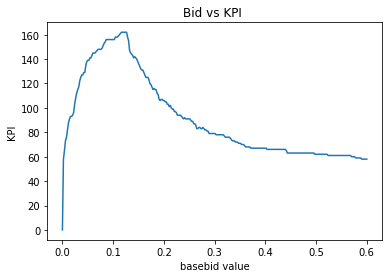

Optimal basebid is:  0.11638795986622072 , Optimal num clicks:  162 , impressions: 131318
budget spent: 5687.000000000001 , avgCPM: 43.30708661417324 , avgCPC: 35.104938271604944
CTR:  0.12336465678734067 %


In [31]:
budget = 6250
optimal_basebid = 0
optimal_num_clicks = 0
num_won_auctions = 0
base_bids_array = []
num_clicks_array = []

avg_ctr = 7.375e-04 


# Line search to find optimal base bid
for bid in np.linspace(0.0, 0.6, 300):
    validation_final['bid'] = bid * (predicted_XGB_CTR/avg_ctr)
    
    Won_Auctions = validation_final[ (validation_final['bid'] >= validation_final['slotprice']) & (validation_final['bid'] >=validation_final['payprice']) ]
    exceeding_indexes = np.flatnonzero( (Won_Auctions['payprice'].cumsum().values) > budget  )
    
    # Budget exceeded
    if len(exceeding_indexes) > 0:
        ExceedBudget_Index = exceeding_indexes[0]
        num_clicks = Won_Auctions[:ExceedBudget_Index]['click'].sum()
        budget_spent = Won_Auctions[:ExceedBudget_Index]['payprice'].sum()
        num_won_auctions = len(Won_Auctions[:ExceedBudget_Index])
    
    # No budget exceeded
    else:
        num_clicks = Won_Auctions[:]['click'].sum()
        budget_spent = Won_Auctions[:]['payprice'].sum()
        num_won_auctions = len(Won_Auctions[:])
    
    # Max clicks achieved --> optimal basebid
    if num_clicks > optimal_num_clicks:
        optimal_basebid = bid
        optimal_num_clicks = num_clicks
        optimal_impressions = num_won_auctions
        opt_budget = budget_spent
    
    print ('Without Budget limit: ', Won_Auctions['payprice'].sum(), 'Num Clicks: ',Won_Auctions['click'].sum() , 
           'With Budget limit: ', budget_spent, "Num Clicks: ", num_clicks , 
           "CTR: ", num_clicks/num_won_auctions, 'won impressions: ', num_won_auctions , "basebid: ", bid)
    
    base_bids_array.append(bid)
    num_clicks_array.append(num_clicks)


# bids vs number of clicks, plot
plt.plot(base_bids_array, num_clicks_array)
plt.xlabel("basebid value")
plt.ylabel("KPI")
plt.title("Bid vs KPI ")
plt.show()


avgCPM = (opt_budget/optimal_impressions)*1000
avgCPC = (opt_budget/optimal_num_clicks)

optimal_bids = optimal_basebid * (predicted_XGB_CTR/avg_ctr)


print ("Optimal basebid is: ", optimal_basebid, ", Optimal num clicks: ", optimal_num_clicks, ', impressions:', optimal_impressions)
print('budget spent:', opt_budget , ', avgCPM:', avgCPM, ', avgCPC:', avgCPC)
print('CTR: ' , (optimal_num_clicks/optimal_impressions)*100, '%')

## Optimal bids for the validation set


In [19]:
optimal_bids = optimal_bids * 1000
aaa = pd.DataFrame(optimal_bids)
aaa.to_csv('optimalbids_validation_linear.csv')

## Optimal bids for the test set

Similar steps of feature engineering must take place

In [32]:
test_final = preprocess_df(test)
test_final = tag(test)

In [33]:
# Dropping the same columns as before, except for bidid
test_final = test_final.drop(columns = ['usertag', 'useragent', 'slotheight', 'slotwidth','urlid','IP', 'domain', 'url','slotid', 'keypage','userid', 'creative', 'slotvisibility','slotformat'])

In [34]:
test_final_final = pd.DataFrame(0, index=range(0,len(test_final)), columns=list( train_final.columns ))

for col in train_final:
    if col in test_final:
        test_final_final[col] = np.array( test_final[col] )

In [35]:
test_final_final.shape

(303375, 80)

In [36]:
test_final_final['adexchange'] = test_final_final['adexchange'].fillna(4)
X_test = test_final_final.astype(float)
X_test = X_test.drop(columns = ['bidprice', 'payprice', 'click'])

test_pred = model_xgb.predict(X_test)

#### pCTR for the test set

In [37]:
test_pCTR = model_xgb.predict_proba(X_test)[:,1]
test_pCTR

array([0.15464635, 0.25799447, 0.01843025, ..., 0.01211043, 0.14158835,
       0.01245131], dtype=float32)

#### Recalibration of the pCTR

In [38]:
test_pCTR_final = test_pCTR/(test_pCTR+((1-test_pCTR)/w)) 
test_pCTR_final

array([1.3336581e-03, 2.5317755e-03, 1.3704824e-04, ..., 8.9481917e-05,
       1.2026303e-03, 9.2032140e-05], dtype=float32)

In [39]:
final_bids = (optimal_basebid * test_pCTR_final / avg_ctr)

In [40]:
bbb = test[['bidid']]
bbb['bidprice'] = final_bids*1000
bbb.to_csv('Group_14_linear.csv', index=False)

C:\Users\apogn\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
